In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
import scipy

#from google.colab import runtime


In [2]:
#Hyperparameters
lr = 0.00001
momentum = 0 #default = 0
weight_decay = 0.05 #default = 0
dampening = 0 #default = 0

#Other
batch_size = 16
epochs = 100

In [3]:
transforms = {
    'train':
    #Composing several transforms together
    transforms.Compose(
        [
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(),
            transforms.GaussianBlur(1),
            transforms.RandomAdjustSharpness(1),
            transforms.RandomPerspective(),
            transforms.ToTensor(), #To tensor object
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Mean = 0.5, std = 0.5
            transforms.Resize((256,256)) #Speeds up model without losing too much information
        ]),

    'trainOld':
    transforms.Compose(
        [
            transforms.TrivialAugmentWide(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256)),
        ]
    ),

    'val':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ]),

    'test':
    transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((256,256))
        ])
}

In [4]:
train_data = datasets.Flowers102(root='./data', split='train', transform=transforms['train'], download=True)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 344862509/344862509 [00:23<00:00, 14382906.66it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 526253.59it/s]


100%|██████████| 14989/14989 [00:00<00:00, 23625863.46it/s]


In [5]:
val_data = datasets.Flowers102(root='./data', split='val', transform=transforms['val'], download=False)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [6]:
test_data = datasets.Flowers102(root='./data', split='test', transform=transforms['test'], download=False)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
#dataloaders = {
#    'train': train_dataloader,
#    'val': val_dataloader
#}

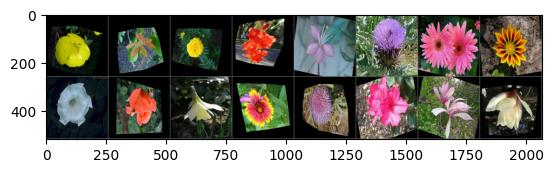

In [8]:
# Show the images in the batch to see what the transforms are doing to them
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_dataloader)
for i in range(1):
  images, lbls = next(dataiter)
  imshow(torchvision.utils.make_grid(images))

In [9]:
#Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [10]:
#Architecture inspired by https://poloclub.github.io/cnn-explainer/#article-input
#and PyTorch for Deep Learning & Machine Learning – Full Course by freeCodeCamp.org https://www.youtube.com/watch?v=V_xro1bcAuA
class CNNv4(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    #Block is comprised of multiple layers
    self.convLayer1 = self.ConvLayers(input_shape, hidden_units)

    self.convLayer2 = self.ConvLayers(hidden_units, hidden_units)
    self.classLayer2 = self.ClassLayers(hidden_units, 64, output_shape)

    self.convLayer3 = self.ConvLayers(hidden_units, hidden_units)
    self.classLayer3 = self.ClassLayers(hidden_units, 32, output_shape)

    self.convLayer4 = self.ConvLayers(hidden_units, hidden_units)
    self.classLayer4 = self.ClassLayers(hidden_units, 16, output_shape)

    self.finalClass = nn.Sequential(
        nn.Linear(in_features=hidden_units*3,
                  out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256,
                  out_features=output_shape)
    )



  def ConvLayers(self, input_shape, hidden_units):
    return nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

  def ClassLayers(self, hidden_units, image_size, output_shape):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*image_size*image_size,
                  out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512,
                  out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256,
                  out_features=output_shape)
        )



  def forward(self, x):
    x1 = self.convLayer1(x)

    x2 = self.convLayer2(x1)
    c2 = self.classLayer2(x2)

    x3 = self.convLayer3(x2)
    c3 = self.classLayer3(x3)

    x4 = self.convLayer4(x3)
    c4 = self.classLayer4(x4)
    #print(x.shape)

    cFinal = self.finalClass(torch.cat((c2,c3,c4), 1))
    return c4

In [11]:
model = CNNv4(input_shape=3,
              hidden_units=102,
              output_shape=102).to(device)
print(model)

CNNv4(
  (convLayer1): Sequential(
    (0): Conv2d(3, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convLayer2): Sequential(
    (0): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(102, 102, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classLayer2): Sequential(
  

In [12]:
#Loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
#optimiser = torch.optim.SGD(model.parameters(),
#                            lr=lr,
#                            momentum=momentum,
#                            weight_decay=weight_decay,
#                            dampening=dampening)
optimiser = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)


In [13]:
#Train the model using the training data
def train(dataloader, model, loss_fn, optimiser):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.train()
  running_loss, running_corrects = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    running_loss += loss.item()
    running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

    # Backpropagation
    loss.backward()
    optimiser.step()
    optimiser.zero_grad()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"Train Error: \nAccuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")
  return ave_loss, corrects


In [14]:
#Validate the models progress using the validation data
def valTest(dataloader, model, loss_fn, split):
  size = len(dataloader.dataset)
  batches = len(dataloader)
  model.eval()
  running_loss, running_corrects = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)

      running_loss += loss.item()
      running_corrects += torch.count_nonzero(pred.argmax(1)==y).item()

  ave_loss = running_loss/batches
  corrects = running_corrects/size

  print(f"{split} Error: \n Accuracy: {(100*corrects):.2f}%, Avg loss: {ave_loss:.6f} \n")

  return ave_loss, corrects


In [2]:
def pltHist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(121)
  plt.plot(hist['train_loss'],'-o')
  plt.plot(hist['val_loss'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation loss')

  plt.subplot(122)
  plt.plot(hist['train_accuracy'],'-o')
  plt.plot(hist['val_accuracy'],'-o')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Val'])
  plt.title('Train vs Validation Accuracy')

In [16]:
def trainValLoop(model, loss_fn, optimiser, epochs):
  train_loss_hist = []
  train_acc_hist = []
  val_loss_hist = []
  val_acc_hist = []

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs} -------------------------------")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimiser)
    val_loss, val_acc = valTest(val_dataloader, model, loss_fn, 'Validate')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

  hist = {'train_loss':train_loss_hist, 'train_accuracy':train_acc_hist,
          'val_loss':val_loss_hist, 'val_accuracy':val_acc_hist}
  pltHist(hist)
  valTest(test_dataloader, model, loss_fn, 'Test')

  return hist


In [17]:
hist = trainValLoop(model, loss_fn, optimiser, epochs)

Epoch 1/100 -------------------------------
Train Error: 
Accuracy: 1.27%, Avg loss: 4.629343 

Validate Error: 
 Accuracy: 2.84%, Avg loss: 4.467608 

Epoch 2/100 -------------------------------
Train Error: 
Accuracy: 2.35%, Avg loss: 4.414390 

Validate Error: 
 Accuracy: 5.10%, Avg loss: 4.272969 

Epoch 3/100 -------------------------------
Train Error: 
Accuracy: 4.80%, Avg loss: 4.221172 

Validate Error: 
 Accuracy: 8.63%, Avg loss: 4.090978 

Epoch 4/100 -------------------------------


KeyboardInterrupt: 

In [ ]:
PATH = './CNNv4.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print("#Hyperparameters")
print(f"lr = {lr:.5f}")
print(f"momentum = {momentum}")
print(f"weight_decay = {weight_decay}")
print(f"dampening = {dampening}")
print()
print("#Other")
print(f"batch_size = {batch_size}")
print(f"epochs = {epochs}")

In [ ]:
print(hist)

In [ ]:
#Stops Google stealing my credits
#runtime.unassign()

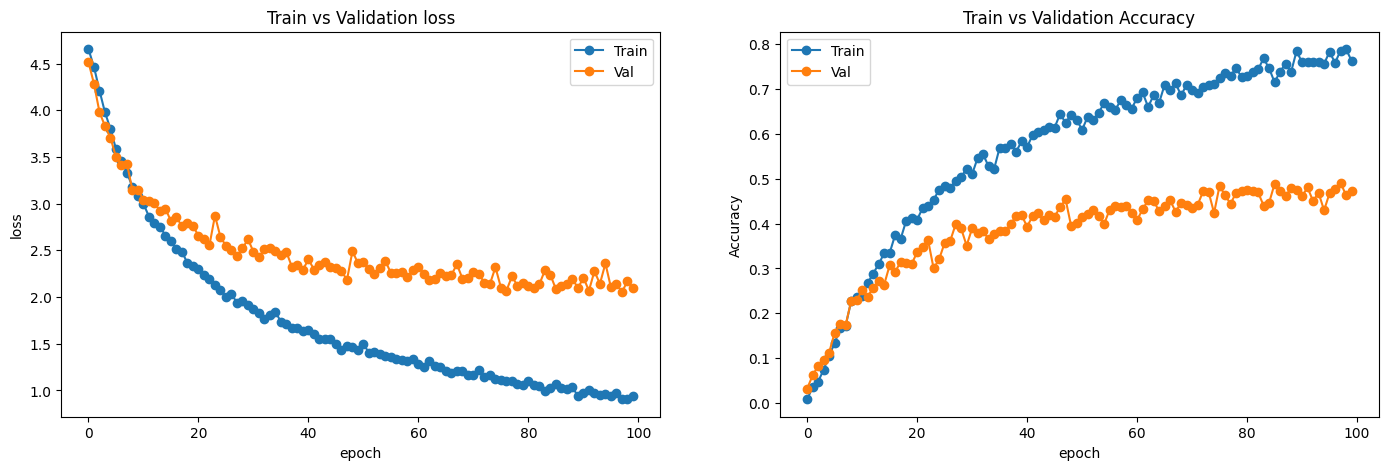

In [3]:
histVik = {'train_loss': [4.654073946177959, 4.463918425142765, 4.211150500923395, 3.9767059199512005, 3.799827743321657, 3.585344858467579, 3.4559440314769745, 3.332974810153246, 3.1766419522464275, 3.0836153253912926, 2.9987440891563892, 2.861028481274843, 2.790620654821396, 2.7513962760567665, 2.658509187400341, 2.5999121963977814, 2.5187965612858534, 2.485249960795045, 2.3621122539043427, 2.334598332643509, 2.3009926844388247, 2.238918336108327, 2.1950840782374144, 2.132301164790988, 2.0708678402006626, 2.005716059356928, 2.0361141711473465, 1.935707926750183, 1.9571225047111511, 1.9106024596840143, 1.871414102613926, 1.8246520925313234, 1.760079275816679, 1.8096701744943857, 1.8358462173491716, 1.7377188336104155, 1.7080386988818645, 1.6730361077934504, 1.667108166962862, 1.6401696624234319, 1.647562675178051, 1.6021243147552013, 1.5557530112564564, 1.5478799007833004, 1.5549820130690932, 1.5009920746088028, 1.4310406856238842, 1.4748491970822215, 1.4609361123293638, 1.4382158406078815, 1.497287591919303, 1.4028208293020725, 1.4167617382481694, 1.3947926759719849, 1.365935972891748, 1.3528974121436477, 1.3416678002104163, 1.3216774798929691, 1.3112490866333246, 1.3399591213092208, 1.2872816026210785, 1.255853021517396, 1.3152449745684862, 1.257691077888012, 1.2549798414111137, 1.2090289322659373, 1.1910262294113636, 1.2078540902584791, 1.2027665488421917, 1.1601743958890438, 1.16816530469805, 1.2213501632213593, 1.145244650542736, 1.1601746939122677, 1.1175042586401105, 1.1115001048892736, 1.1029722969979048, 1.1000242428854108, 1.067099110223353, 1.060814362950623, 1.1026748474687338, 1.0531206326559186, 1.0497268494218588, 0.9885984798893332, 1.0221786070615053, 1.0689302515238523, 1.0297628371044993, 1.0196842327713966, 1.032258078455925, 0.9410996567457914, 0.9757946375757456, 1.0079027749598026, 0.9675228418782353, 0.9523316035047174, 0.9670519409701228, 0.9417395698837936, 0.9720376785844564, 0.9077083989977837, 0.905820541549474, 0.9365731943398714], 'train_accuracy': [0.008823529411764706, 0.03529411764705882, 0.04803921568627451, 0.07450980392156863, 0.10588235294117647, 0.13333333333333333, 0.1676470588235294, 0.17254901960784313, 0.22647058823529412, 0.2372549019607843, 0.23823529411764705, 0.2676470588235294, 0.28823529411764703, 0.30980392156862746, 0.3333333333333333, 0.33431372549019606, 0.37450980392156863, 0.3656862745098039, 0.40588235294117647, 0.4117647058823529, 0.4088235294117647, 0.4343137254901961, 0.44019607843137254, 0.45294117647058824, 0.47549019607843135, 0.4843137254901961, 0.47941176470588237, 0.4950980392156863, 0.503921568627451, 0.5215686274509804, 0.5098039215686274, 0.546078431372549, 0.553921568627451, 0.5274509803921569, 0.5215686274509804, 0.5686274509803921, 0.5686274509803921, 0.5774509803921568, 0.5598039215686275, 0.5833333333333334, 0.5705882352941176, 0.5970588235294118, 0.6029411764705882, 0.6088235294117647, 0.615686274509804, 0.6137254901960785, 0.6441176470588236, 0.6245098039215686, 0.6421568627450981, 0.6313725490196078, 0.6088235294117647, 0.6372549019607843, 0.6303921568627451, 0.6470588235294118, 0.6676470588235294, 0.6598039215686274, 0.6519607843137255, 0.6745098039215687, 0.6637254901960784, 0.6558823529411765, 0.6794117647058824, 0.692156862745098, 0.6598039215686274, 0.6852941176470588, 0.6686274509803921, 0.7088235294117647, 0.6980392156862745, 0.7127450980392157, 0.6852941176470588, 0.7088235294117647, 0.6980392156862745, 0.6911764705882353, 0.7049019607843138, 0.7088235294117647, 0.7098039215686275, 0.7245098039215686, 0.734313725490196, 0.7294117647058823, 0.746078431372549, 0.7264705882352941, 0.7284313725490196, 0.7372549019607844, 0.7431372549019608, 0.7676470588235295, 0.746078431372549, 0.7147058823529412, 0.7382352941176471, 0.7558823529411764, 0.7372549019607844, 0.7843137254901961, 0.7588235294117647, 0.7607843137254902, 0.7598039215686274, 0.7588235294117647, 0.7558823529411764, 0.7823529411764706, 0.7578431372549019, 0.7852941176470588, 0.788235294117647, 0.7627450980392156], 'val_loss': [4.516694895923138, 4.282271288335323, 3.9803601540625095, 3.8310415372252464, 3.7061779089272022, 3.498183201998472, 3.4170152097940445, 3.426048068329692, 3.1418105252087116, 3.1504478994756937, 3.043100180104375, 3.0309146344661713, 3.0105833606794477, 2.9191535990685225, 2.9476530430838466, 2.8107146434485912, 2.8555205119773746, 2.7561202943325043, 2.79361379891634, 2.7655722312629223, 2.6532690208405256, 2.622767279855907, 2.5573243089020252, 2.8721480313688517, 2.641527334228158, 2.5489615346305072, 2.505796394776553, 2.443784154485911, 2.5203862860798836, 2.6201705373823643, 2.484322978183627, 2.427309194114059, 2.5153781650587916, 2.521566857583821, 2.4974621611181647, 2.4519176012836397, 2.4802073892205954, 2.3216663617640734, 2.3410908648511395, 2.293474927311763, 2.4049436994828284, 2.294098942540586, 2.348322667821776, 2.376855103764683, 2.3186249167192727, 2.312981210881844, 2.279156120494008, 2.1840110865887254, 2.490865500178188, 2.3617613231763244, 2.374074306571856, 2.296223318669945, 2.2467355192638934, 2.307269213721156, 2.3861444680951536, 2.255140969529748, 2.255404577124864, 2.2709882063791156, 2.2188913780264556, 2.2862119683995843, 2.3207112746313214, 2.2492693066596985, 2.186598498839885, 2.188625330571085, 2.2608979595825076, 2.225466097705066, 2.239026569761336, 2.349402198102325, 2.1978891456965357, 2.205291480757296, 2.2736020614393055, 2.2512067414354533, 2.1483327609021217, 2.1402033981867135, 2.319305689074099, 2.1013353795278817, 2.067966815084219, 2.2214299314655364, 2.1221884647384286, 2.155081179458648, 2.1130436452804133, 2.091692857677117, 2.138478212291375, 2.286829002434388, 2.2370546294841915, 2.0840476045850664, 2.1146453199908137, 2.1416294230148196, 2.1981013286858797, 2.094403997529298, 2.20794437546283, 2.068204568233341, 2.2768485413398594, 2.1415299675427377, 2.3601049492135644, 2.10320508480072, 2.140898435842246, 2.053104148712009, 2.1694039748981595, 2.0984279988333583], 'val_accuracy': [0.03235294117647059, 0.061764705882352944, 0.08333333333333333, 0.09509803921568627, 0.11274509803921569, 0.1568627450980392, 0.17549019607843136, 0.17352941176470588, 0.22745098039215686, 0.22941176470588234, 0.25098039215686274, 0.2372549019607843, 0.2568627450980392, 0.2725490196078431, 0.26372549019607844, 0.30686274509803924, 0.29215686274509806, 0.31470588235294117, 0.3127450980392157, 0.30980392156862746, 0.3362745098039216, 0.3480392156862745, 0.3627450980392157, 0.3, 0.3205882352941177, 0.3568627450980392, 0.3607843137254902, 0.3980392156862745, 0.3892156862745098, 0.3509803921568627, 0.3892156862745098, 0.3784313725490196, 0.38333333333333336, 0.36470588235294116, 0.3764705882352941, 0.3843137254901961, 0.38333333333333336, 0.3980392156862745, 0.4176470588235294, 0.41862745098039217, 0.3931372549019608, 0.4166666666666667, 0.42254901960784313, 0.4068627450980392, 0.4196078431372549, 0.41568627450980394, 0.4362745098039216, 0.453921568627451, 0.39509803921568626, 0.4019607843137255, 0.4147058823529412, 0.42058823529411765, 0.4303921568627451, 0.4176470588235294, 0.3990196078431373, 0.4303921568627451, 0.4392156862745098, 0.4372549019607843, 0.44019607843137254, 0.4245098039215686, 0.40784313725490196, 0.43137254901960786, 0.4519607843137255, 0.45098039215686275, 0.42745098039215684, 0.44019607843137254, 0.4519607843137255, 0.4264705882352941, 0.44607843137254904, 0.442156862745098, 0.4343137254901961, 0.4411764705882353, 0.4715686274509804, 0.47058823529411764, 0.4235294117647059, 0.4843137254901961, 0.4627450980392157, 0.4441176470588235, 0.46862745098039216, 0.4725490196078431, 0.4745098039215686, 0.4715686274509804, 0.4696078431372549, 0.44019607843137254, 0.44607843137254904, 0.48823529411764705, 0.4725490196078431, 0.46078431372549017, 0.47941176470588237, 0.47549019607843135, 0.46078431372549017, 0.4803921568627451, 0.45, 0.46862745098039216, 0.4294117647058823, 0.4676470588235294, 0.4774509803921569, 0.49117647058823527, 0.4627450980392157, 0.4715686274509804]}

pltHist(histVik)